In [26]:
import mingpt
from mingpt.prisonerTrainer import PrisonerTrainer
from mingpt.model import GPT
from torchinfo import summary

In [27]:
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-pico'
model_config.vocab_size = 2
model_config.block_size = 128
model_config.alg_name = "actde"

train_config = PrisonerTrainer.get_default_config()
train_config.learning_rate = 5e-4 # many possible options, see the file
train_config.max_iters = 500
train_config.gamma = 0.50
train_config.whiten = False
train_config.alg_name = model_config.alg_name

In [28]:
model = GPT(model_config)
summary(model)
trainer = PrisonerTrainer(train_config, model)
print(trainer.equilibriumDiscount(startCoop=True), trainer.equilibriumDiscount(startCoop=False))
print(0.5 * trainer.equilibriumDiscount(startCoop=True) + 0.5 * trainer.equilibriumDiscount(startCoop=False))
trainer.run()

number of parameters: 0.01M
running on device cuda
tensor(0.5477) tensor(0.4523)
tensor(0.5000)
 iter  1000 / 1000 / 1000/ 1000 10001000404 / 1000612 / 1000/ 1000884 / 1000 1000936 / 1000/ 1000

In [29]:
import json
with open("rewStats.json", 'r') as file:
    iter_list, rew_dict, avg_rets, loss_list = json.load(file)
print(iter_list, rew_dict, avg_rets)

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308, 312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360, 364, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412, 416, 420, 424, 428, 432, 436, 440, 444, 448, 452, 456, 460, 464, 468, 472, 476, 480, 484, 488, 492, 496, 500, 504, 508, 512, 516, 520, 524, 528, 532, 536, 540, 544, 548, 552, 556, 560, 564, 568, 572, 576, 580, 584, 588, 592, 596, 600, 604, 608, 612, 616, 620, 624, 628, 632, 636, 640, 644, 648, 652, 656, 660, 664, 668, 672, 676, 680, 684, 688, 692, 696, 700, 704, 708, 712, 716, 720, 724, 728, 732, 736, 740, 744, 748, 752, 756, 760, 764, 768, 772, 776, 780, 784, 788, 792, 796, 800, 804, 808, 812, 816, 82

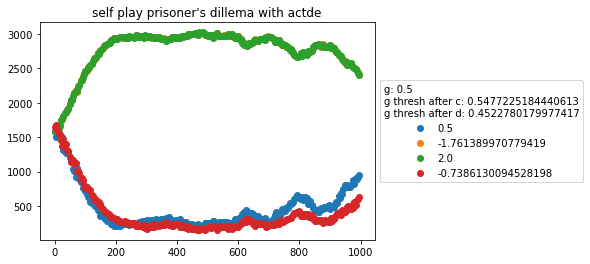

In [30]:
import matplotlib.pyplot as plt
import numpy as np

alg_name = train_config.alg_name
if alg_name == "reject":
    alg_name = "rejection sampling"

plt.figure()
title = f"self play prisoner's dillema with {alg_name}"
plt.title(title)
for k in rew_dict:
    plt.scatter(iter_list, rew_dict[k], label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=f"g: {train_config.gamma}\ng thresh after c: {trainer.equilibriumDiscount(startCoop=True)}\ng thresh after d: {trainer.equilibriumDiscount(startCoop=False)}")
plt.savefig(alg_name + ".jpg", bbox_inches='tight')
plt.show()